In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from collections import defaultdict
from scipy.stats.stats import pearsonr

In [2]:
df = pd.read_csv('training.csv') 

In [3]:
df.head()

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,326,1,10/25/2010,ADESA,2008,2,KIA,SPECTRA,EX,4D SEDAN EX,...,9605.0,10650.0,NaN,NaN,5546,33619,FL,6100.0,0,533
1,42991,0,5/27/2009,MANHEIM,2006,3,DODGE,STRATUS V6 2.7L V6 M,SXT,4D SEDAN SXT FFV,...,6418.0,7478.0,NaN,NaN,99750,32124,FL,4000.0,0,1630
2,55273,0,3/18/2010,OTHER,2008,2,DODGE,CALIBER,SE,4D WAGON,...,10721.0,11350.0,NaN,NaN,99761,74135,OK,7500.0,0,693
3,29058,0,6/8/2009,OTHER,2005,4,FORD,FREESTAR FWD V6 3.9L,S,PASSENGER 3.9L,...,5702.0,7691.0,NaN,NaN,99761,85018,AZ,4725.0,0,1633
4,34991,0,3/4/2009,MANHEIM,2005,4,CHRYSLER,TOWN & COUNTRY FWD V,Bas,MINIVAN 3.3L,...,6300.0,7856.0,NaN,NaN,20833,75236,TX,5670.0,0,1623


In [7]:
df['MMR_factor'] = ( df['MMRAcquisitionAuctionAveragePrice'] + df['MMRAcquisitonRetailCleanPrice'] + df['MMRCurrentAuctionCleanPrice'] + df['MMRCurrentRetailAveragePrice']) / 4

In [8]:
df_new = df[['VehicleAge','VehOdo','MMR_factor','VehBCost','WarrantyCost']]

In [9]:
df_new.head()

,VehicleAge,VehOdo,MMR_factor,VehBCost,WarrantyCost
0,2,61184,8685.25,6100.0,533
1,3,92383,6459.25,4000.0,1630
2,2,45965,9635.50,7500.0,693
3,4,80169,6217.00,4725.0,1633
4,4,77372,6551.25,5670.0,1623


In [10]:
df.isnull().sum()

RefId                                    0
IsBadBuy                                 0
PurchDate                                0
Auction                                  0
VehYear                                  0
VehicleAge                               0
Make                                     0
Model                                    0
Trim                                  1911
SubModel                                 7
Color                                    7
Transmission                             8
WheelTypeID                           2573
WheelType                             2577
VehOdo                                   0
Nationality                              4
Size                                     4
TopThreeAmericanName                     4
MMRAcquisitionAuctionAveragePrice       13
MMRAcquisitionAuctionCleanPrice         13
MMRAcquisitionRetailAveragePrice        13
MMRAcquisitonRetailCleanPrice           13
MMRCurrentAuctionAveragePrice          245
MMRCurrentA

In [11]:
df_new['MMR_factor'].fillna(df_new['MMR_factor'].median(), inplace = True)

C:\Users\bonin\Anaconda3\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [12]:
df_new.isnull().sum()

VehicleAge      0
VehOdo          0
MMR_factor      0
VehBCost        0
WarrantyCost    0
dtype: int64

In [13]:
scaler = StandardScaler() 
scaler.fit(df_new.head().values)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [14]:
df_new.head().values

array([[2.00000e+00, 6.11840e+04, 8.68525e+03, 6.10000e+03, 5.33000e+02],
       [3.00000e+00, 9.23830e+04, 6.45925e+03, 4.00000e+03, 1.63000e+03],
       [2.00000e+00, 4.59650e+04, 9.63550e+03, 7.50000e+03, 6.93000e+02],
       [4.00000e+00, 8.01690e+04, 6.21700e+03, 4.72500e+03, 1.63300e+03],
       [4.00000e+00, 7.73720e+04, 6.55125e+03, 5.67000e+03, 1.62300e+03]])

In [15]:
scaler.transform(df_new.head().values)

array([[-1.11803399, -0.63346427,  0.84867757,  0.41777513, -1.37838809],
       [ 0.        ,  1.29833365, -0.75829442, -1.3333781 ,  0.81495646],
       [-1.11803399, -1.57580321,  1.53467269,  1.58521061, -1.05848369],
       [ 1.11803399,  0.54206006, -0.93317715, -0.72881329,  0.82095467],
       [ 1.11803399,  0.36887378, -0.69187868,  0.05920566,  0.80096064]])

In [16]:
scaler.inverse_transform(scaler.transform(df_new.head().values))

array([[2.00000e+00, 6.11840e+04, 8.68525e+03, 6.10000e+03, 5.33000e+02],
       [3.00000e+00, 9.23830e+04, 6.45925e+03, 4.00000e+03, 1.63000e+03],
       [2.00000e+00, 4.59650e+04, 9.63550e+03, 7.50000e+03, 6.93000e+02],
       [4.00000e+00, 8.01690e+04, 6.21700e+03, 4.72500e+03, 1.63300e+03],
       [4.00000e+00, 7.73720e+04, 6.55125e+03, 5.67000e+03, 1.62300e+03]])

In [17]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df_new.values)

In [18]:
X[:5]

array([[0.22222222, 0.50823324, 0.22860583, 0.16716917, 0.01009096],
       [0.33333333, 0.78957905, 0.17001494, 0.10960969, 0.16600341],
       [0.22222222, 0.3709916 , 0.25361751, 0.20554216, 0.03283115],
       [0.44444444, 0.67943585, 0.16363864, 0.12948142, 0.16642979],
       [0.44444444, 0.65421311, 0.17243648, 0.15538318, 0.16500853]])

In [19]:
kmeans = KMeans(n_clusters=3, n_init=10, max_iter=100)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [20]:
kmeans.labels_[:5]

array([2, 0, 2, 0, 0])

In [21]:
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2]), array([21830, 21577, 14979], dtype=int64))

In [22]:
hist, bins = np.histogram(kmeans.labels_, 
                          bins=range(0, len(set(kmeans.labels_)) + 1))
dict(zip(bins, hist))

{0: 21830, 1: 21577, 2: 14979}

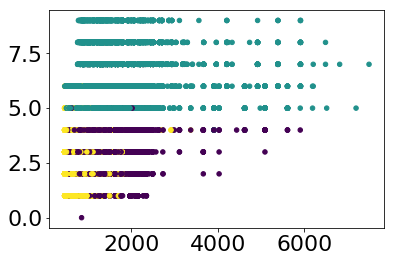

In [29]:
plt.scatter(df_new['WarrantyCost'], df_new['VehicleAge'],
            c=kmeans.labels_, s=20)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

In [30]:
kmeans.cluster_centers_

array([[0.36657135, 0.6634047 , 0.24763447, 0.19580748, 0.13017627],
       [0.66488984, 0.65139372, 0.16917208, 0.16921625, 0.14064717],
       [0.31633325, 0.43821646, 0.22011213, 0.18980045, 0.05885275]])

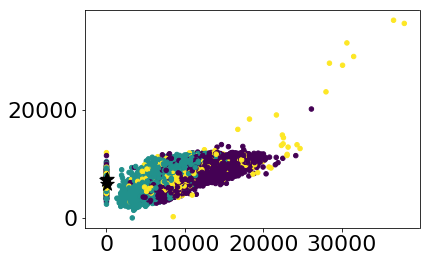

In [31]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)

plt.scatter(df_new['MMR_factor'], df_new['VehBCost'], c=kmeans.labels_, 
            s=20)
plt.scatter(centers[:, 0], centers[:, 3], s=200, marker='*', c='k')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

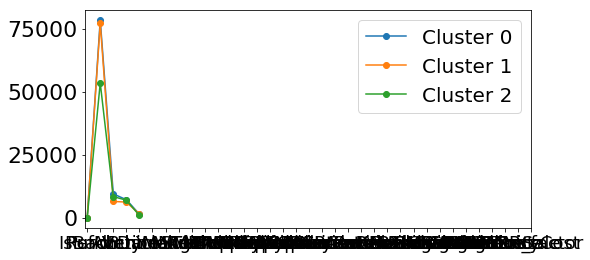

In [32]:
plt.figure(figsize=(8, 4))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(range(0, len(df.columns)), df.columns, fontsize=18)
plt.legend(fontsize=20)
plt.show()

In [33]:
df_new.head()

,VehicleAge,VehOdo,MMR_factor,VehBCost,WarrantyCost
0,2,61184,8685.25,6100.0,533
1,3,92383,6459.25,4000.0,1630
2,2,45965,9635.50,7500.0,693
3,4,80169,6217.00,4725.0,1633
4,4,77372,6551.25,5670.0,1623


In [35]:
print('SSE %s' % kmeans.inertia_)
print('Silhouette %s' % silhouette_score(X, kmeans.labels_))

SSE 1914.3098606696467


KeyboardInterrupt: 

In [36]:
sse_list = list()
max_k = 50
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X)
    
    sse = kmeans.inertia_
    sse_list.append(sse)

KeyboardInterrupt: 